In [1]:
import maboss
import ginsim
import pandas as pd 
import numpy as np
import os
import shutil
from collections import defaultdict
from statsmodels.stats.power import TTestIndPower
import ast


from identification_patients.get_patients_sens_res import get_patients

from identification_drug.identification_drug import identify_drug


from create_generic_models.create_generic_patients_cfgs import create_generic_patients_cfgs_bnds

from create_generic_models.update_phenotypes_generic_models import generic_models_update_phenotypes
from pre_process_data.pre_process_genes import create_table_rna_seq_patients, process_genes

from create_person_models.tailor_cfgs_patients import personalized_patients_genes_cfgs
from create_person_models.tailor_bnd_mutations import personalized_patients_mutations_bnds
from create_person_models.tailor_bnd_tsg_onco_mutations import tailor_bnd_tsg_onco_mut
from create_person_models.tailor_bnd_cnv import tailor_bnd_cnv_cm


from MaBoSS_simulation.maboss_phenotype_patient import compute_phenotype_table, compute_phenotype_mean_group_validation, compute_mean_phenotype_values

from pre_process_data.identify_mutations_patients import identif_mutations_kras_egfr

# # from pre_process_profiles_table_data_lung import create_genes_patients

from stats.stats_proba import compute_mannwhitneyu_test_means, compute_kruskal, compute_power_calculation, compute_power_calculation_genes
from results_MaBoSS_visualization.boxplot_phenotype import create_boxplot
from results_MaBoSS_visualization.create_phenotypes_patients_table import vizualise_table_phenotype_condition, plot_side_by_side_heatmaps
from results_MaBoSS_visualization.patients_ids_phenotype_table import create_combined_table_patients
from gene_enrichment.genes_signature import compute_genes_mean_signature, create_results_gene_enrichment
from pre_process_data.preprocess_mutations import preprocess_mutations_ds
from pre_process_data.pre_process_cnv import preprocess_cnv



Step 0: Import data 

In [2]:
# Import Data

annotations_models = pd.read_csv('data/model_list_20250407.csv')
mutations_data = pd.read_csv('data/mutations_all_20250318.csv')
drug_data = pd.read_csv('data/drug_sensitivity.csv')

montagud_data = (
    pd.read_csv('data/Montagud_inter_nodes_data.csv', header=1)
    .loc[:, ['Target node', 'Interaction type', 'Source']])
rna_seq_data = pd.read_csv('data/rnaseq_merged/rnaseq_merged_20250117.csv')
cnv_data = pd.read_csv('data/cellmodel_data/cnv_summary_20250207.csv')


models_depmap_annotation = pd.read_csv('data/cellmodel_data/model_list_20250423.csv')
mutations_data_depseq = pd.read_csv('data/depmap_data/OmicsSomaticMutations.csv')



/var/folders/83/pqwsm5cn7vscbq8l3fnf30qr0000gn/T/ipykernel_34446/4029099413.py:15: DtypeWarning: Columns (22,50,56,57,58,59,61) have mixed types. Specify dtype option on import or set low_memory=False.
  mutations_data_depseq = pd.read_csv('data/depmap_data/OmicsSomaticMutations.csv')


Step 1: Identify the best drug to keep (the one with most resistant and sensitive, and with big variance) 
        & specify the phenotypes of our model

In [3]:
tissue_remove = 'Haematopoietic and Lymphoid'
# drugs_df = identify_drug(drug_data, annotations_models, tissue_remove)

drug_interest = 'Refametinib' #Pictilisib, 'Avagacestat' AZD8931 
tissue_interest = 'PAN_CANCER'


type_models = 'genes_models'


# models inputs
inputs_list = ['EGF', 'FGF', 'TGFB', 'Androgen', 'Hypoxia', 'Nutrients', 'Carcinogen', 'Acidosis', 'TNF', 'SPOP']


# models outputs
phenotype_interest = ["Proliferation","Invasion","DNA_Repair","Migration","Apoptosis"]


number_patients = 20

Step 2: Create the folders where the models are saved and where the results will be saved

In [4]:

# folder where the results will be saved
folder_result = f'results/{drug_interest}_{tissue_interest}'

folder_pers_models=f'models/personalized_boolean_{drug_interest}_{tissue_interest}'




# Generic model that will be duplicated to create personalized models
folder_generic_models = f'{folder_pers_models}/generic_models'


src_dir_generic_models = f'models/prostate/generic/{type_models}'

# copy the generic model from the models to validation generic models

folder_generic_models_cfg = f'{folder_generic_models}/Montagud2022_Prostate_Cancer.cfg'
folder_generic_models_bnd = f'{folder_generic_models}/Montagud2022_Prostate_Cancer.bnd'


folder_res_results_single_input = f'{folder_result}/resistant_results/only_gene_expression/single_input_on'
folder_sens_results_single_input = f'{folder_result}/sensitive_results/only_gene_expression/single_input_on'



folder_result_resistant = f'{folder_res_results_single_input}/phenotype_distribution_patients'
folder_result_sensitive = f'{folder_sens_results_single_input}/phenotype_distribution_patients'

folder_result_res_sen = f'{folder_result}/sensitive_resistant_results/genes_diff_expressed'


generic_pers_models_folder_res = f"{folder_pers_models}/resistant_patient/generic_models"
generic_pers_models_folder_sens = f"{folder_pers_models}/sensitive_patient/generic_models"

folder_models_res = f'{folder_pers_models}/resistant_patient/personalized_boolean_modified/models_gene_expression'
folder_models_sens = f'{folder_pers_models}/sensitive_patient/personalized_boolean_modified/models_gene_expression'




results_mean_folder_res = f"{folder_res_results_single_input}/phenotype_mean"
results_mean_folder_sens = f"{folder_sens_results_single_input}/phenotype_mean"



os.makedirs(folder_result_resistant, exist_ok=True)
os.makedirs(folder_result_sensitive, exist_ok=True)
os.makedirs(folder_result_res_sen, exist_ok=True)

os.makedirs(folder_generic_models, exist_ok=True)
os.makedirs(folder_models_res, exist_ok=True)
os.makedirs(folder_models_sens, exist_ok=True)

os.makedirs(results_mean_folder_res, exist_ok=True)
os.makedirs(results_mean_folder_res, exist_ok=True)

for filename in os.listdir(src_dir_generic_models):
    src_file = os.path.join(src_dir_generic_models, filename)
    dst_file = os.path.join(folder_generic_models, filename)
    if os.path.isfile(src_file):
        shutil.copy(src_file, dst_file)


Step 3: Get the n top patients Ids

In [5]:
# top_resistant_ids, top_sensitive_ids= get_patients(drug_data, annotations_models, drug_interest, tissue_interest)
top_resistant_ids, top_sensitive_ids, drug_tissue_data= get_patients(number_patients, drug_data, annotations_models, drug_interest, tissue_interest = None, tissue_remove = tissue_remove)
patients_ids = top_sensitive_ids + top_resistant_ids

/Users/romane/repos/icr/Attractor-Resistance/identification_patients/get_patients_sens_res.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotations_models_filtered.rename(


Step 4: Pre-process data- Montagud nodes, rna-seq (filtered with patients IDs and Montagud nodes)

In [6]:
# # Pre-process Montagud nodes

# Keep only the nodes of montagud not specific to Prostate 
montagud_nodes = list(set(montagud_data['Target node'].tolist() + montagud_data['Source'].tolist()))
montagud_nodes = [node for node in montagud_nodes if node != '0/1']
montagud_nodes = [node.upper() for node in montagud_nodes if isinstance(node, str)]
to_remove = ['FUSED_EVENT', 'AR_ERG']

montagud_nodes = [node for node in montagud_nodes if node not in to_remove]
montagud_nodes = list(set(montagud_nodes))

In [7]:
# Pre-process RNA seq data (keep only montagud_nodes and patients ids) and create table for high and low expression
rna_seq_data_filtered = process_genes(patients_ids, montagud_nodes, rna_seq_data)
table_rna_seq_patients = create_table_rna_seq_patients(rna_seq_data_filtered)


# Pre-process patients (keep only the patients id with gene expression data)
top_resistant_ids = list(set(table_rna_seq_patients.index) & set(top_resistant_ids))
top_sensitive_ids= list(set(table_rna_seq_patients.index) & set(top_sensitive_ids))

patients_ids = top_resistant_ids + top_sensitive_ids


# preprocess cnv data
cnv_data_filtered = preprocess_cnv(cnv_data, montagud_nodes,patients_ids)

/Users/romane/repos/icr/Attractor-Resistance/pre_process_data/pre_process_genes.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rna_seq_data.rename(columns={"gene_symbol": "gene_name"}, inplace=True)


Step 5: Create generic boolean networks with the sensitive and resistant ID names


In [8]:
# create_generic_patients_cfgs_bnds(folder_generic_models_cfg, folder_generic_models_bnd, folder_pers_models, top_resistant_ids, top_sensitive_ids, drug_interest, tissue_interest)

Update the phenotypes of interest for the analysis


In [9]:
# generic_models_update_phenotypes(phenotype_interest, generic_pers_models_folder_res, generic_pers_models_folder_res)
# generic_models_update_phenotypes(phenotype_interest, generic_pers_models_folder_sens, generic_pers_models_folder_sens)

Step 6: Personalize the cfg files with genes/ proteins


In [10]:
# personalized_patients_genes_cfgs(rna_seq_data, montagud_nodes, generic_pers_models_folder_res, folder_models_res, patients_ids, table_rna_seq_patients, drug_interest)
# personalized_patients_genes_cfgs(rna_seq_data, montagud_nodes, generic_pers_models_folder_sens, folder_models_sens, patients_ids, table_rna_seq_patients, drug_interest)

In [11]:
# personalize copy nb variation
# tailor_bnd_cnv_cm(cnv_data_filtered,folder_models_res, folder_models_sens, drug_interest)

Step 7: compute the phenotype distribution 

In [12]:
# Compute phenotype distribution for each patient

# for patient  in top_resistant_ids:
#     compute_phenotype_table(folder_result_resistant, folder_models_res, patient, inputs_list, phenotype_interest, drug_interest)
    
# for patient  in top_sensitive_ids:
#     compute_phenotype_table(folder_result_sensitive, folder_models_sens, patient, inputs_list, phenotype_interest, drug_interest)
    

In [13]:
# # Combine data together 
def collect_group_data(group_folder_path):
    combined_data = defaultdict(lambda: defaultdict(list))

    for file in os.listdir(group_folder_path):
        if file.startswith("_SID") and file.endswith(".csv"):
            file_path = os.path.join(group_folder_path, file)
            df = pd.read_csv(file_path, index_col=0)

            for input_name in df.index:
                for phenotype in df.columns:
                    value = df.at[input_name, phenotype]
                    combined_data[input_name][phenotype].append(float(value))

    combined_results = pd.DataFrame.from_dict(combined_data, orient='index')
    combined_results.to_csv(os.path.join(group_folder_path, "combined_results.csv"))

    return combined_results


In [14]:
# stats test between the two combined dataframes (sensitive vs resistant)

df_res_combined = pd.read_csv(f'{folder_result_resistant}/combined_results.csv', index_col=0)  # index: inputs, columns: phenotypes
df_sens_combined = pd.read_csv(f'{folder_result_sensitive}/combined_results.csv', index_col=0)

Power calculation for every condition-phenotype pairs

In [15]:
nb_patients_required = compute_power_calculation(df_res_combined, df_sens_combined)

/Users/romane/repos/icr/Attractor-Resistance/stats/stats_proba.py:267: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  nb_patients_required.loc[condition][phenotype] = sample_size


Results: using a T-test with alpha of 0.05 we will have 80% power to detect an effect size of 0.62 * StDev (ie effect > 10) with a minimum study size of 19 patients per group.

In [16]:
significant_kruskal_results = compute_kruskal(inputs_list, phenotype_interest, df_res_combined, df_sens_combined)

/Users/romane/repos/icr/Attractor-Resistance/stats/stats_proba.py:50: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  significant_kruskal_results = kruskal_results.applymap(


Step 7: Compute stats test between two mean datasets

In [17]:
patient_res_values =  pd.read_csv(f'{folder_result_resistant}/combined_results.csv')
patient_sens_values = pd.read_csv(f'{folder_result_sensitive}/combined_results.csv')
compute_mannwhitneyu_test_means(folder_result,patient_res_values, patient_sens_values, drug_interest)

Step 8: Vizualise the boxplot of phenotype distribution output

In [18]:
data_greater_side = pd.read_csv(f'{folder_result}/sensitive_resistant_results/p_values_df_mannwhitneyu_greater_sign_{drug_interest}.csv')
data_less_side = pd.read_csv(f'{folder_result}/sensitive_resistant_results/p_values_df_mannwhitneyu_less_sign_{drug_interest}.csv')
data_both_side = pd.read_csv(f'{folder_result}/sensitive_resistant_results/p_values_df_mannwhitneyu_two_sides_{drug_interest}.csv')

signif_df = pd.concat([data_greater_side, data_less_side, data_both_side], axis=0)

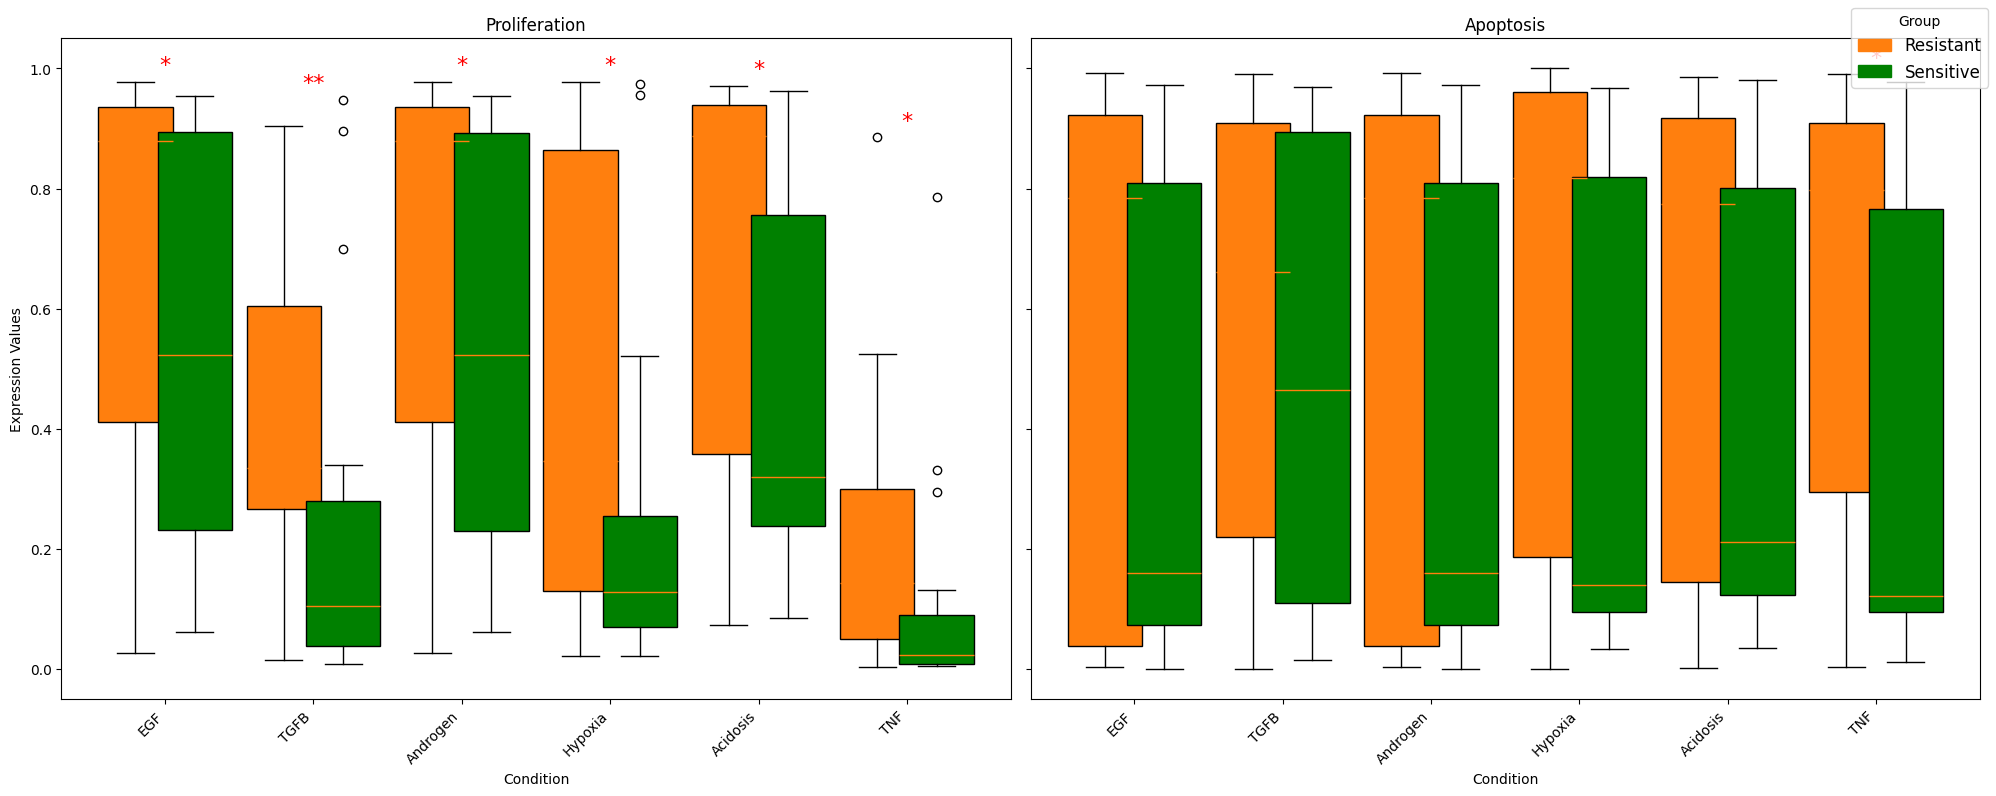

In [29]:
create_boxplot(df_res_combined, df_sens_combined, data_greater_side)

Step 9: create table of patients with conditions- phenotype

Step 10: Create heatmap figure 

/Users/romane/repos/icr/Attractor-Resistance/MaBoSS_simulation/maboss_phenotype_patient.py:178: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  patient_mean.loc[condition][phenotype] = mean
/Users/romane/repos/icr/Attractor-Resistance/MaBoSS_s

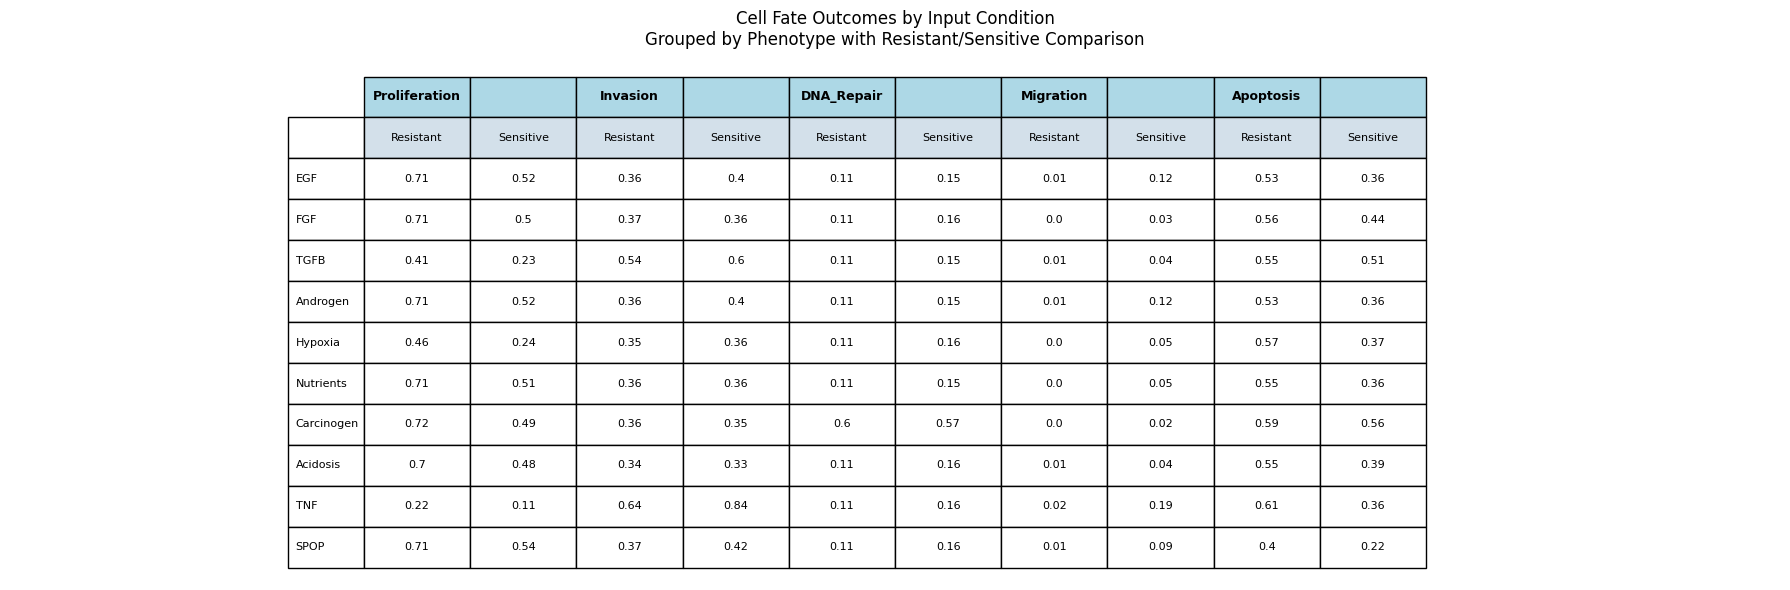

In [20]:
patient_resistant_mean = compute_mean_phenotype_values(df_res_combined)
patient_sensitive_mean = compute_mean_phenotype_values(df_sens_combined)
vizualise_table_phenotype_condition(folder_result, patient_resistant_mean, patient_sensitive_mean)

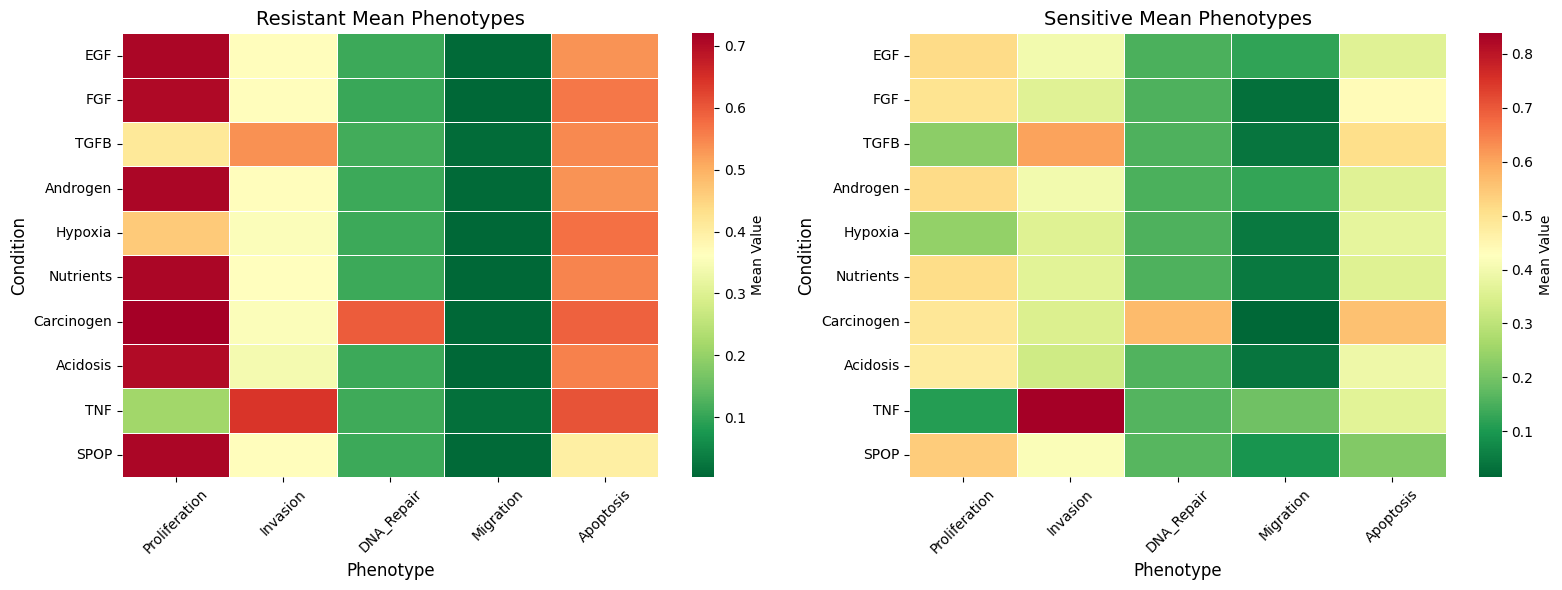

In [21]:
plot_side_by_side_heatmaps(patient_resistant_mean, patient_sensitive_mean, folder_result)

Step 11: Identify genes differently expressed in the patients with high 

In [22]:
res_tables_path = f'{folder_res_results_single_input}/phenotype_distribution_patients'
sens_tables_path = f'{folder_sens_results_single_input}/phenotype_distribution_patients'

greater_sign_results = pd.read_csv(f'{folder_result}/sensitive_resistant_results/p_values_df_mannwhitneyu_greater_sign_{drug_interest}.csv')
conditions_phenotypes_df = greater_sign_results[['Condition', 'Phenotype']]
patients_phenot_table = create_combined_table_patients(res_tables_path, sens_tables_path, folder_result)
results_genes_enrich = create_results_gene_enrichment(rna_seq_data_filtered, patients_phenot_table, top_resistant_ids, top_sensitive_ids, conditions_phenotypes_df, folder_result)

['SIDM00892', 'SIDM00716', 'SIDM00920', 'SIDM00506', 'SIDM00881', 'SIDM01056', 'SIDM00770', 'SIDM00767', 'SIDM01120', 'SIDM00971', 'SIDM00631', 'SIDM00183', 'SIDM00292', 'SIDM00870', 'SIDM00508', 'SIDM00444', 'SIDM00524', 'SIDM00255', 'SIDM00719', 'SIDM00890', 'SIDM00129', 'SIDM00826', 'SIDM01240', 'SIDM00003', 'SIDM00175', 'SIDM01242', 'SIDM01059', 'SIDM00795', 'SIDM00568', 'SIDM01066', 'SIDM00190', 'SIDM00619', 'SIDM00974', 'SIDM00284', 'SIDM00910', 'SIDM00337', 'SIDM01001', 'SIDM00056']
Saved final phenotype table to: results/Refametinib_PAN_CANCER/sensitive_resistant_results/patients_phenot_table.csv


/Users/romane/repos/icr/Attractor-Resistance/.env/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/Users/romane/repos/icr/Attractor-Resistance/.env/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/Users/romane/repos/icr/Attractor-Resistance/.env/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/Users/romane/repos/icr/Attractor-Resistance/.env/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*sampl

Step 11: check there is not correlation between phenotype distribution and cancer type 


Gene enrichment for EGF Proliferation (as required 19 patients in each group and statistically relevant with Mannwhiteney test)

In [23]:
results_egf_prolif = results_genes_enrich['EGF_Proliferation']
results_egf_prolif['diff_means'] = results_egf_prolif['Group Resistant Mean'] - results_egf_prolif['Group Sensitive Mean'] 
results_egf_prolif.sort_values(by = 'P-value', ascending=True).head()

results_egf_prolif.sort_values(by = 'diff_means', ascending=False)

,Group Resistant Mean,Group Sensitive Mean,Group Resistant Variance,Group Sensitive Variance,P-value,diff_means
FOXA1,6.138972,0.810763,4.444998,1.357682,0.000005,5.328209
FGFR3,3.083833,1.241584,3.717680,2.620573,0.002038,1.842249
JUN,5.705689,4.275132,1.021197,3.323063,0.005948,1.430557
FRS2,4.566767,3.387037,1.863444,0.776740,0.001840,1.17973
BCL2,3.056356,1.890132,4.427137,0.786149,0.033114,1.166224
E2F1,5.857372,4.714232,1.133118,0.566966,0.000574,1.143141
APAF1,3.844061,2.972342,0.885300,0.349764,0.001728,0.871719
EZH2,6.094678,5.226942,1.163182,0.984916,0.015358,0.867736
BIRC5,6.562172,5.701453,0.608337,1.021507,0.006602,0.86072
BAD,6.209117,5.366679,0.344646,0.348568,0.000112,0.842438


Results:
- FOXA1: TF, key roles in hormone receptor signaling and modulates tumor growth and metastatic potential
- FGFR3: receptor tyrosine kinase for FGF ligands, promoting cell prolif (frequently overexpressed in cancers)
- FRS2: overexpressed in several cancers, enhancing proliferative/ migratory responses
- BCL2, BIRC5: anti-apoptotic protein -> promotes cell survival by inhibiting programmed cell death pathways; for overepxressed in cancer to evade apoptois.
- EZH2: silencing TSG via H3K27 trimethylation, overexpression linked to aggressive, proliferative cancers

Check that the genes overexpression are not related to tissue 

In [24]:
resistant_group_ids_models = annotations_models[annotations_models['model_id'].isin(top_resistant_ids)].copy()
sensitive_group_ids_models = annotations_models[annotations_models['model_id'].isin(top_sensitive_ids)].copy()

In [25]:
resistant_counts = resistant_group_ids_models['tissue'].value_counts()
total_counts = annotations_models['tissue'].value_counts()
fraction_resistant = resistant_counts / total_counts
print(fraction_resistant[fraction_resistant.notna()])


sensitive_counts = sensitive_group_ids_models['tissue'].value_counts()
total_counts_sens = annotations_models['tissue'].value_counts()
fraction_sensitive = sensitive_counts / total_counts_sens
print(fraction_sensitive[fraction_sensitive.notna()])


resistant_counts = resistant_group_ids_models['gender'].value_counts()
total_counts = annotations_models['gender'].value_counts()
fraction_resistant = resistant_counts / total_counts
print(fraction_resistant[fraction_resistant.notna()])


sensitive_counts = sensitive_group_ids_models['gender'].value_counts()
total_counts_sens = annotations_models['gender'].value_counts()
fraction_sensitive = sensitive_counts / total_counts_sens
print(fraction_sensitive[fraction_sensitive.notna()])


tissue
BREAST                       0.085366
ESOPHAGUS                    0.008403
LUNG                         0.031546
PERIPHERAL NERVOUS SYSTEM    0.019608
Name: count, dtype: float64
tissue
BREAST                       0.012195
LARGE INTESTINE              0.004505
PERIPHERAL NERVOUS SYSTEM    0.019608
SKIN                         0.096296
STOMACH                      0.019231
THYROID                      0.080000
Name: count, dtype: float64
gender
Male       0.008446
Female     0.009357
Unknown    0.004444
Name: count, dtype: float64
gender
Female    0.009357
Male      0.009291
Name: count, dtype: float64


Result: As the ratio do not vary that much, the results observed do not seem to be tissue-dependent, same for the gender

In [26]:
gene_interest = 'E2F1'
sample_size = compute_power_calculation_genes(gene_interest,rna_seq_data_filtered, top_resistant_ids, top_sensitive_ids)
print(sample_size)

61.1378856615947


In [27]:
# # power calculation for FOXA1 -> do it also for E2F1 

# group_gene_data_res = list(rna_seq_data_filtered[
#     (rna_seq_data_filtered['model_id'].isin(top_resistant_ids)) &
#     (rna_seq_data_filtered['gene_symbol'] == 'FOXA1')
# ]['rsem_tpm'])


# group_gene_data_sens = list(rna_seq_data_filtered[
#     (rna_seq_data_filtered['model_id'].isin(top_sensitive_ids)) &
#     (rna_seq_data_filtered['gene_symbol'] == 'FOXA1')
# ]['rsem_tpm'])


# res_patients_mean = np.mean(group_gene_data_res)
# sens_patients_mean = np.mean(group_gene_data_sens)


# res_patients_std = np.std(group_gene_data_res)
# sens_patients_std = np.std(group_gene_data_sens)

# n_res_group = len(top_resistant_ids)
# n_sens_group = len(top_sensitive_ids)

# sd_pooled = np.sqrt(
#     ((n_res_group - 1) * res_patients_std**2 + (n_sens_group - 1) * sens_patients_std**2)
#     / (n_res_group + n_sens_group - 2)
# )

# d = res_patients_mean -sens_patients_mean/sd_pooled


# # Set parameters
# effect_size = d              # Cohen's d
# alpha = 0.05                 # Significance level
# power = 0.80                 # Desired power
# alternative = 'two-sided'    # Equivalent to "two.sample" in R

# # Initialize power analysis object
# analysis = TTestIndPower()

# # Compute required sample size per group
# sample_size = analysis.solve_power(effect_size=effect_size, power=power, alpha=alpha, alternative=alternative)

# print(f"Required sample size per group: {float(sample_size):.2f}")